### Keras RNN으로 여행자 수 예측

1. 패키지 수입 및 파라미터 설정

In [ ]:
# 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
# 파라미터 
MY_PAST = 12 # 24로 해도 손실값 늘어나고 6 해도 늘어남, 24는 over-fitting(과적합)이기 때문이다
MY_SPLIT = 0.8
MY_HIDDEN = 300
MY_SHAPE = (MY_PAST, 1) # 2차원 데이터
MY_EPOCH = 300
#MY_BATCH = 64

2. 데이터 처리

In [ ]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/airline.csv', 
                  header=None, 
                  usecols=[1]) #사용할 열이 1번 열이다.

# 샘플 출력
print(raw.head(15))
print(raw.describe())

      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115
13  126
14  141
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


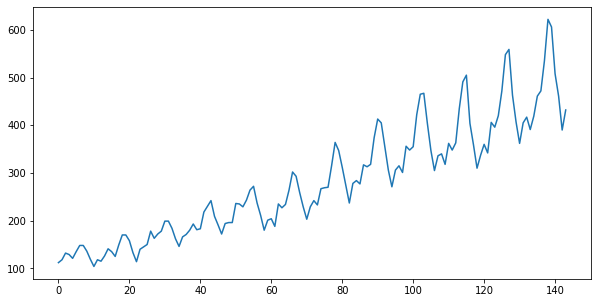

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(raw)

<class 'numpy.ndarray'>
[-0.46911197 -0.44594595 -0.39189189 -0.4034749  -0.43436293 -0.38030888
 -0.33011583 -0.33011583 -0.37644788 -0.44208494 -0.5        -0.44594595
 -0.45752896 -0.41505792 -0.35714286 -0.38030888 -0.41891892 -0.32625483
 -0.24517375 -0.24517375 -0.29150579 -0.38803089 -0.46138996 -0.36100386
 -0.34169884 -0.32239382 -0.21428571 -0.27220077 -0.23745174 -0.21428571
 -0.13320463 -0.13320463 -0.19111969 -0.27606178 -0.33783784 -0.26061776
 -0.24131274 -0.20656371 -0.15637066 -0.2027027  -0.19498069 -0.05984556
 -0.01351351  0.03281853 -0.09459459 -0.16409266 -0.23745174 -0.15250965
 -0.14478764 -0.14478764  0.00965251  0.00579151 -0.01737452  0.03667954
  0.11776062  0.14864865  0.01351351 -0.08687259 -0.20656371 -0.12548263
 -0.11389961 -0.17567568  0.00579151 -0.02509653  0.0019305   0.11776062
  0.26447876  0.22972973  0.0984556  -0.01737452 -0.11776062 -0.01737452
  0.03281853 -0.0019305   0.12934363  0.13706564  0.14092664  0.31467181
  0.503861    0.43822394  0

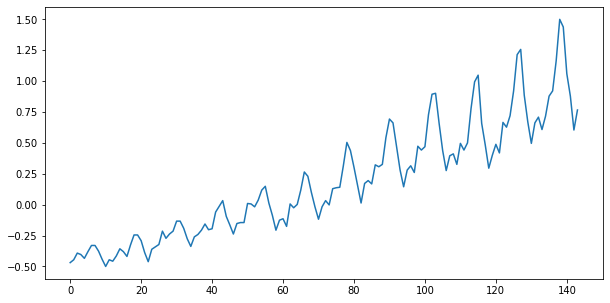

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler() # 이 문제 에서는 MinMax가 낫다
#s_data = StandardScaler() 
s_data = scaler.fit_transform(raw)
s_data = s_data * 2 - 0.5


print(type(s_data)) #numpy로 전환된다.
print(s_data.flatten())
plt.figure(figsize=(10,5))
plt.plot(s_data)

In [ ]:
# 데이터 분할
data = []
for i in range(len(s_data) - MY_PAST):  #144-12
  data.append(s_data[i: i + MY_PAST + 1])   #12+1=13, s_data의 크기는 144, MY_PAST는 12

print('한 묶음의 크기:',len(data[0]))
print('총 묶음 수:', len(data))
print('첫번째 묶음 내용:\n', data[0])
print('두번째 묶음 내용:\n', data[1])

한 묶음의 크기: 13
총 묶음 수: 132
첫번째 묶음 내용:
 [[-0.46911197]
 [-0.44594595]
 [-0.39189189]
 [-0.4034749 ]
 [-0.43436293]
 [-0.38030888]
 [-0.33011583]
 [-0.33011583]
 [-0.37644788]
 [-0.44208494]
 [-0.5       ]
 [-0.44594595]
 [-0.45752896]]
두번째 묶음 내용:
 [[-0.44594595]
 [-0.39189189]
 [-0.4034749 ]
 [-0.43436293]
 [-0.38030888]
 [-0.33011583]
 [-0.33011583]
 [-0.37644788]
 [-0.44208494]
 [-0.5       ]
 [-0.44594595]
 [-0.45752896]
 [-0.41505792]]


In [ ]:
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data)
print(type(data))

#묶음들을 임의로 섞음
#np.random.shuffle(data)
print(data.shape)
#print(data)
#(132,13,1) 1이 3차원 데이터를 뜻한다.

# 데이터를 입력과 출력으로 분할
X_data = data[:, 0:MY_PAST] #분할 기능, 0열부터 12
Y_data = data[:, -1] #또는 13이라 해도 가능하다.([:, 12:13])

print('입력 데이터 모양:', X_data.shape)
print('출력 데이터 모양:', Y_data.shape)

<class 'list'>
<class 'numpy.ndarray'>
(132, 13, 1)
입력 데이터 모양: (132, 12, 1)
출력 데이터 모양: (132, 1)


In [ ]:
# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size=MY_SPLIT, shuffle = False)


# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양:', X_train.shape)
print('학습용 출력 데이터 모양:', Y_train.shape)
print('평가용 입력 데이터 모양:', X_test.shape)
print('평가용 출력 데이터 모양:', Y_test.shape)



학습용 입력 데이터 모양: (105, 12, 1)
학습용 출력 데이터 모양: (105, 1)
평가용 입력 데이터 모양: (27, 12, 1)
평가용 출력 데이터 모양: (27, 1)


3. 인공 신경망 구현

In [ ]:
# RNN 구현
model = Sequential()
model.add(InputLayer(input_shape=MY_SHAPE))
model.add(LSTM(units=MY_HIDDEN))
model.add(Dense(units=1, activation='tanh'))#'sigmoid'))
print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [ ]:
# RNN 학습 설정
model.compile(optimizer= 'rmsprop', loss = 'mse')#, metrics=['acc']) #rmsprop보다 adam이 더 손실값 줄여준다.

print('학습 시작')
begin = time()

model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, verbose=0)

end = time()
print('학습 시간:{:.2f}'.format(end-begin))

학습 시작
학습 시간:7.47


5. 인공 신경망 평가

In [ ]:
# RNN 평가
score = model.evaluate(x=X_test, y=Y_test, verbose=0)

print('최종 손실값:', score)#[0])
#print('최종 정확도:', score[1]) 정확도는 필요없다.




최종 손실값: 0.03824668750166893


6. 인공 신경망 예측

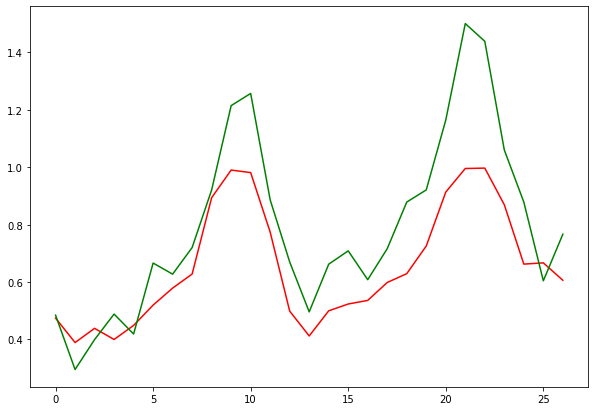

In [ ]:
# RNN으로 예측

pred = model.predict(x=X_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred,'r') #여기서 r은 (빨간색)
plt.plot(Y_test, 'g')
#랜덤이다 셔플 끄면 랜덤 아님

In [ ]:
print('역전환 전:', pred)
print('역전환 전 모양:', pred.shape)

# 데이터 역전환
pred = scaler.inverse_transform(pred)

print('역전환 후:', pred)
print('역전환 후 모양:', pred.shape)

# squeeze 결과
tmp = np.squeeze(pred).astype(int)
print('squeeze 후:', tmp)
print('squeeze 후 모양:', tmp.shape)

역전환 전: [[0.47434932]
 [0.3892355 ]
 [0.43872556]
 [0.39997113]
 [0.44882238]
 [0.519626  ]
 [0.5787937 ]
 [0.62778956]
 [0.89371896]
 [0.9898978 ]
 [0.98109096]
 [0.7738018 ]
 [0.4986492 ]
 [0.41218728]
 [0.49970397]
 [0.5234534 ]
 [0.5359816 ]
 [0.5984497 ]
 [0.62903595]
 [0.72546494]
 [0.9132872 ]
 [0.99537337]
 [0.99669576]
 [0.8692494 ]
 [0.662388  ]
 [0.66673326]
 [0.6061125 ]]
역전환 전 모양: (27, 1)
역전환 후: [[349.71295]
 [305.624  ]
 [331.25983]
 [311.18506]
 [336.49   ]
 [373.1663 ]
 [403.81516]
 [429.195  ]
 [566.9464 ]
 [616.7671 ]
 [612.20514]
 [504.82935]
 [362.3003 ]
 [317.51303]
 [362.84665]
 [375.1489 ]
 [381.6385 ]
 [413.99695]
 [429.84064]
 [479.79086]
 [577.08276]
 [619.6034 ]
 [620.2884 ]
 [554.2712 ]
 [447.117  ]
 [449.36786]
 [417.96628]]
역전환 후 모양: (27, 1)
squeeze 후: [349 305 331 311 336 373 403 429 566 616 612 504 362 317 362 375 381 413
 429 479 577 619 620 554 447 449 417]
squeeze 후 모양: (27,)


역전환 전 정답: [[0.48455598]
 [0.2953668 ]
 [0.3996139 ]
 [0.48841699]
 [0.41891892]
 [0.66602317]
 [0.62741313]
 [0.72007722]
 [0.92084942]
 [1.21428571]
 [1.25675676]
 [0.88610039]
 [0.66988417]
 [0.496139  ]
 [0.66216216]
 [0.70849421]
 [0.60810811]
 [0.71621622]
 [0.87837838]
 [0.92084942]
 [1.16409266]
 [1.5       ]
 [1.43822394]
 [1.05984556]
 [0.87837838]
 [0.6042471 ]
 [0.76640927]]
역전환 후 정답: [[355.]
 [257.]
 [311.]
 [357.]
 [321.]
 [449.]
 [429.]
 [477.]
 [581.]
 [733.]
 [755.]
 [563.]
 [451.]
 [361.]
 [447.]
 [471.]
 [419.]
 [475.]
 [559.]
 [581.]
 [707.]
 [881.]
 [849.]
 [653.]
 [559.]
 [417.]
 [501.]]


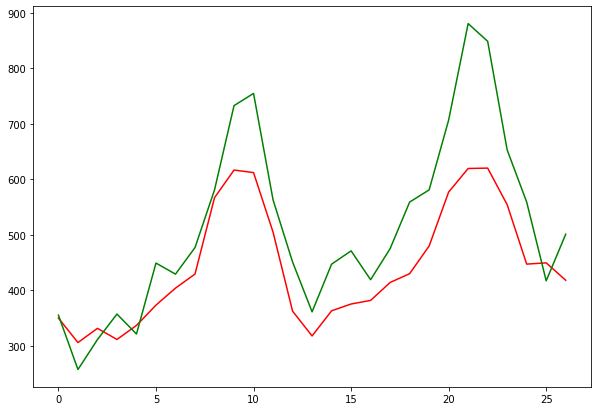

In [ ]:
# 정답 출력
print('역전환 전 정답:', Y_test)
Y_test = scaler.inverse_transform(Y_test)
print('역전환 후 정답:', Y_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred,'r') #여기서 r은 (빨간색)
plt.plot(Y_test, 'g')
# 두 그래프 모양 차이는 없지만 range가 다르다